##  this is to use to generate segmenation dataset
## The label less 20 will be ignored. The raw numpy dicom values will be instored in np file

In [ ]:
import os
from PIL import Image
from glob import glob
import numpy as np
import tensorflow as tf

In [ ]:
# find the dataset root dir
train_root_dir = "E:/dataset/Leisang/myTry/BleedingDataDCM/train/"
print("train_root_dir:", train_root_dir)

# find all the case folder list
train_case_list = glob(train_root_dir + "*")
# print("case_list:", case_list)
print("len of case_list:", len(train_case_list))



In [ ]:
# for each case list start to make npy file by checking the label file
delay_datatype = np.short
marked_datatype =  np.ubyte
#     label = np.fromfile(mask_path, dtype = datatype)
label_path = None
input_path =  None

num_nonzeros_label_list=[]
num_nonzeros_equal_one = []
for each_case in train_case_list:
    # for the raw files fisrt
    print(each_case)
    raw_files = glob(each_case + "/*.raw")
    dicom_files = glob(each_case + "/*.DCM")
    
    print("len of dicoms:", len(dicom_files))
#     print("raw_files in one case:", raw_files)
#     print("len of raws:", len(raw_files))
    
#     if "ZA-021_001" in each_case or "ZA-022_001" in each_case or "ZA-029_001" in each_case or  "ZA-033_001" in each_case or "ZA-037_001" in each_case or "ZA-038_001" in each_case  or "ZA-041_001" in each_case  or "ZA-043_001" in each_case or "ZA-044_001" in each_case: 
#         print("bad delay file xxxxxx------------------------->")
#         continue

#     if len(raw_files) == 2: # read delay as raw npy.
    for each_path in raw_files:
        if "marked" in each_path:
            label_path =  each_path
#                 elif "delay" in each_path:
#                     input_path =  each_path
        else:
            pass
#             print("input path:", input_path)
    print("label path:", label_path)

#             # read inputs--->
#             inputs = np.fromfile(input_path, dtype = delay_datatype)
#             print("input raw shape:", inputs.shape)
#             # reshape the read file to the  512,x512s
#             reshaped_inputs =  inputs.reshape([-1, 512, 512])
#             print("reshape inputs shape:", reshaped_inputs.shape)
#             assert  reshaped_inputs.shape[0] ==  len(dicom_files) , 'len of dicoms is not equal to the raw input values'

    # read labels
    labels = np.fromfile(label_path, dtype = marked_datatype)
#             print("input raw shape:", labels.shape)
#             labels[labels> 0] = 255
    reshaped_labels =  labels.reshape([-1, 512, 512])
    print("reshape labels shape:", reshaped_labels.shape)
    assert  reshaped_labels.shape[0] ==  len(dicom_files)  , 'len of dicoms is not equal to the raw label values'

    # count the number of non-zeros in each label
    for i in range(reshaped_labels.shape[0]):
        num_nonzero = np.count_nonzero(reshaped_labels[i])
        if num_nonzero>0:
            num_nonzeros_label_list.append(num_nonzero)
#         if num_nonzero ==1:
#             num_nonzeros_equal_one.append(num_nonzero)


    print("--------------------------")
#         delay_values = np.fromfile(mask_path, dtype = datatype)
    pass
   

In [ ]:
print("len(num_nonzeros_equal_one)", num_nonzeros_label_list.count(1))
# plot histogram of num_nonzeros_label_list
import matplotlib.pyplot as plt
plt.hist(num_nonzeros_label_list, bins=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], color='b',
         edgecolor='k', align='left')
plt.xlabel('# of nonzeros pixels for each slice')
plt.ylabel('count')
plt.show()


In [ ]:
# plot histogram of num_nonzeros_label_list
bins =  range(1, max(num_nonzeros_label_list))
print(bins)
import matplotlib.pyplot as plt
plt.hist(num_nonzeros_label_list, bins = bins, color='b',
         edgecolor='k')
# plt.hist(num_nonzeros_label_list, color='b',
#          edgecolor='k', align='left')
plt.xlabel('# of nonzeros pixels for each slice')
plt.ylabel('count')
plt.show

In [ ]:
# count numbers of labels < 10 pixels
total = 0
for i in range(1,10):
 
    count =  num_nonzeros_label_list. count(i)
    print(str(i), ":", count)
    total = total + count
print("total:", total)
print("total non-zero positive slice:", len(num_nonzeros_label_list))

## prepare dataset for train_positive , trian_negative, val_positive, val_negative


In [ ]:
# read excel to check whether need to flip the label
!pip install xlrd

In [ ]:
import xlrd

# give the location of the file
train_excel_loc = "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/TrainfilpOrNot.xlsx"
print("train_excel_loc:", train_excel_loc)
val_excel_loc = "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/ValfilpOrNot.xlsx"
print("val_excel_loc:", val_excel_loc)

In [ ]:
# get work_book of excel
train_wb = xlrd.open_workbook(train_excel_loc)
# get train filp colomn
sheet =  train_wb.sheet_by_index(0)
print("sheet:", sheet)

# extract_number_of rows
print(sheet.nrows)

In [ ]:
## define TF records feature type and feature description:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# Create a dictionary with features that may be relevant. # create tf.example message
def image_example(each_dicom_path, seg_label, cls_label):
    feature = {
      
        'dicom_path': _bytes_feature(each_dicom_path.encode()),
        'seg_label': _bytes_feature(seg_label.tostring()), 
        'cls_label': _int64_feature(cls_label),
        
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

train_positive_samples_file = 'train_positive_samples.tfrecords'
train_negative_samples_file = 'train_negative_samples.tfrecords'

val_positive_samples_file = 'val_positive_samples.tfrecords'
val_negative_samples_file = 'val_negative_samples.tfrecords'




In [ ]:
import pydicom
from IPython import display
# for train data set ------------------------->
# loop to get the flip colom value
train_case_names =  []
train_case_flips = []
for i in range(1, sheet.nrows):
    train_case_names.append(sheet.cell_value(i, 0))
    train_case_flips.append(sheet.cell_value(i, 1))
    
# convert flip notes into integer 
print("train_case_flips:", train_case_flips)
train_case_flips =[int(s) for s in train_case_flips] 
print("train_case_names:", train_case_names)
print("train_case_flips:", train_case_flips)
print("len of train case data:", len(train_case_names))
print("len of train flip data:", len(train_case_flips))

# check train case list
print("train case list len:", len(train_case_list))
assert len(train_case_names) ==  len(train_case_flips), " len of cases names does not macthed with flip len in train excel "
assert len(train_case_list) ==  len(train_case_names), " len of cases in the train folder not macthed with cases in train excel "

my_positive_exmaple ={}
my_negative_exmaple={}

for case_index, each_case in enumerate(train_case_list):
    print(each_case)
    # get case name from case list:
    each_case_str = os.path.split(each_case) 
    print("each_case_str:", each_case_str)
    case_name =  each_case_str[-1]
    print("case name:", case_name)
    print("case index:", i, "case name:", train_case_names[case_index])
    # check case name match or not
    assert case_name ==  train_case_names[case_index]

    # read_labels for specified case name
    raw_files = glob(each_case + "/*.raw")
    dicom_files = glob(each_case + "/*.DCM")
    # get label path
    for each_path in raw_files:
        if "marked" in each_path:
            label_path =  each_path
    print("label path:", label_path)
    # read labels
    labels = np.fromfile(label_path, dtype = marked_datatype)
    reshaped_labels =  labels.reshape([-1, 512, 512])
    print("reshape labels shape:", reshaped_labels.shape)
    print("len of dicoms in this case:", len(dicom_files))
    assert  reshaped_labels.shape[0] ==  len(dicom_files)  , 'len of dicoms is not equal to the raw label values'

   # check whether needs to flip the label
    if train_case_flips[case_index] ==1: # flip the enitre label
        train_final_case_labels = np.flip(reshaped_labels, 0)
    else: 
        train_final_case_labels =  reshaped_labels

    None_zero_label_index = []
    # read inputs
    for dicom_index, each_dicom in enumerate(dicom_files):
#         print("reading current dicom index:", dicom_index)
#         print(each_dicom)
        #read dicoms
#         ds = pydicom.dcmread(each_dicom)
#          # get dcm input pixel content:
#         pix = ds.pixel_array
# #         print("one slice input shape:", pix.shape)
#         # reshape input as [1, shape0, shape1]
#         pix = pix.reshape([1, pix.shape[0], pix.shape[1]])
#         print("one slice reshaped input shape:", pix.shape)
#         # get label with the same index
#         label = reshaped_labels[i]
#         print("one slice label shape:", label.shape)



        # lets make dataset arrays
#         if dicom_index == 0:
#             train_final_case_inputs =  pix
#         else:
#             train_final_case_inputs =  np.concatenate((train_final_case_inputs, pix), axis=0)
#         print("train_final_case_inputs shape:", train_final_case_inputs.shape)


        # Lets generate tf records-----------------------> with feauture formmat ["dicom path":segmentation label(float), classification label(int)]
        # we use tensorflow dicom decoder to decode dicom image , so we only need the dicom paths to be the input feature
        # genarete the classification labels: bleed with 1. No bleed for that slice with 0
        each_slice_label =  train_final_case_labels[dicom_index]

        # count non_zeros value from the each slice label
        num_nonzero = np.count_nonzero(each_slice_label)

        if num_nonzero > 10:  # only consider the # of nonzeros values >10 to be the positive labels
            each_slice_cls_label = 1
            print("num_nonzero:", num_nonzero)
            None_zero_label_index.append(dicom_index+1)
            print("each_slice_label shape:", each_slice_label.shape)
            print("each_slice label range before binarization: [{}, {}]".format(each_slice_label.min(), each_slice_label.max()))

            # binarize the mask label
            each_slice_label[each_slice_label> 0] = 255
            print("each_slice label range before after binarization: [{}, {}]".format(each_slice_label.min(), each_slice_label.max()))

            # genrate positive examples
            my_positive_exmaple[each_dicom]=(each_slice_label, each_slice_cls_label)

        else: # negative examples
            each_slice_cls_label = 0
            my_negative_exmaple[each_dicom]=(each_slice_label, each_slice_cls_label)

        if dicom_index % 20 == 0:
                display.clear_output(wait=True)  

        if dicom_index == len(dicom_files)-1:
            print("total " + str(len(dicom_files)) + " checked ---------------------------------------------------------------------------->")

#         print("my_example:", my_exmaple)

#         # clear the output of the cell
       
    # check the length for each case
    print("generate positive {} positive samples at currently case step:".format(len(my_positive_exmaple)))
    print("generate positive {} negative samples at currently case step:".format(len(my_negative_exmaple)))   
#     # check the dimension of train_inputs and train_labels
#     print("train_final_case_inputs shape:", train_final_case_inputs.shape)
#     print("train_final_case_labels shape:", train_final_case_labels.shape)


#     image_string = open(filename, 'rb').read()
#     tf_example = image_example(image_string, label)  # need image_example function to genearte mesage for writing tf records
#     writer.write(tf_example.SerializeToString())

In [ ]:
count_display = 0
# strat to write postive train dicoms
with tf.io.TFRecordWriter(train_positive_samples_file) as writer:
    for dicom_path, labels in my_positive_exmaple.items():
        print("dicom_path:", dicom_path)
#         dicom_path_string = open(dicom_path, 'rb').read()
        seg_label = labels[0]
        print(seg_label.shape)
        cls_label = labels[1]
        tf_example = image_example(dicom_path, seg_label, cls_label)  # need image_example function to genearte mesage for writing tf records
        writer.write(tf_example.SerializeToString())
        count_display+=1
        if count_display >20:
            display.clear_output(wait=True)  
print("train_positve records generated finished.")
#         print("seg_label shape:", labels[0].shape)
#         print("cls_label:", labels[1])

In [ ]:

# start to write negative train 
with tf.io.TFRecordWriter(train_negative_samples_file) as writer:
    for dicom_path, labels in my_negative_exmaple.items():
        print("dicom_path:", dicom_path)
        dicom_path_string = open(dicom_path, 'rb').read()
        seg_label = labels[0]
        cls_label = labels[1]
        tf_example = image_example(dicom_path_string, seg_label, cls_label)  # need image_example function to genearte mesage for writing tf records
        writer.write(tf_example.SerializeToString())
        count_display+=1
        if count_display >20:
            display.clear_output(wait=True)  
print("train_negative records generated finished.")

## read generated tfrecords to check the dataset

In [ ]:
import tensorflow_io as tfio
train_positive_dataset = tf.data.TFRecordDataset('train_positive_samples.tfrecords')

# Create a dictionary describing the features.
image_feature_description = {
        'dicom_path': tf.io.FixedLenFeature([], tf.string),
        'seg_label': tf.io.FixedLenFeature([], tf.string), 
        'cls_label': tf.io.FixedLenFeature([], tf.int64),
}


def _parse_image_function(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # Parse the input tf.Example proto using the dictionary above.
    
    
    # decode dicom
    dicom_path = parsed_features["dicom_path"]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.io.decode_raw(parsed_features['seg_label'], tf.uint8)
    return dicom_path, input_image, seg_label,  parsed_features["cls_label"]


parsed_train_positive_dataset = train_positive_dataset.map(_parse_image_function)


In [ ]:
# window the input
def winwise(input,LB,HB):
    # 20 ,380 for range (-32768, 32767)
    # for tf input , (0, 65535)-? LB =  32788, 33148
    input[input<LB] = LB # low boundary , if < LW , set to LW
    input[input>HB] = HB # high boundary, if > Hw, Set to 255
    return input

# print(len(parsed_train_positive_dataset))
BUFFER_SIZE =512
# random shuffle the train positive dagtaset
parsed_train_positive_dataset = parsed_train_positive_dataset.shuffle(BUFFER_SIZE)


# 


for image_features in parsed_train_positive_dataset.take(10):
    dicom_path =  image_features[0]
    input =  image_features[1]
#     dicom_path = image_features[0].numpy()
    target = image_features[2]
    cls_label = image_features[3]
    print("dicom_path:", dicom_path)
    print("input_image.shape", input.shape)
#     print("dicom_path", dicom_path)
#     print("dicom_path:", dicom_path)
    print("seg_label", target.shape)
    print("cls_label", cls_label)
    
#     # reshape label 
#     target =  tf.reshape(target, input.shape)
#     fig, axes = plt.subplots(1,3, figsize=(20,20))
    
#     # 
#     mask =  np.squeeze(target.numpy())
#     input_arr = np.squeeze(winwise(input.numpy(), 32788,33148 ))
#     masked_in = mask + input_arr
#     masked = np.ma.masked_where(mask == 0, mask)
    
#     axes[0].imshow(np.squeeze(winwise(input.numpy(), 32788,33148 )), cmap='gray')
#     axes[0].set_title('input range:[{}, {}]'.format((input.numpy().min()), np.max(input.numpy())))
#     axes[1].imshow(np.squeeze(target.numpy()), cmap='gray')
#     axes[1].set_title('target range:[{}, {}]'.format(np.min(target), np.max(target)))
#     axes[2].imshow(masked, 'jet', interpolation='none', alpha=0.7)
#     axes[2].set_title("maksed_input")
#     print(image_path)
    # rehsape 
#     display.display(display.Image(data=dicom_path))

## Functionmal TFRECORDS generation

In [ ]:
import os
from PIL import Image
from glob import glob
import numpy as np
import tensorflow as tf
import pydicom
from IPython import display
import xlrd





def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# Create a dictionary with features that may be relevant. # create tf.example message
def image_example(each_dicom_path, seg_label, cls_label):
    feature = {
      
        'dicom_path': _bytes_feature(each_dicom_path.encode()),
        'seg_label': _bytes_feature(seg_label.tostring()), 
        'cls_label': _int64_feature(cls_label),
        
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

def make_samples(root_folder_path_for_cases, excel_loc, marked_datatype= np.ubyte):
    
    
    # get case_list
    case_list = glob(root_folder_path_for_cases + "*")
    # print("case_list:", case_list)
    print("len of case_list:", len(case_list))
    
    
    # get work_book of excel
    train_wb = xlrd.open_workbook(excel_loc)
    # get train filp colomn
    sheet =  train_wb.sheet_by_index(0)
    print("sheet:", sheet)

    # extract_number_of rows
    print(sheet.nrows)
    
    case_names =  []
    case_flips = []
    for i in range(1, sheet.nrows):
        case_names.append(sheet.cell_value(i, 0))
        case_flips.append(sheet.cell_value(i, 1))

    # convert flip notes into integer 
    print("case_flips:", case_flips)
    case_flips =[int(s) for s in case_flips] 
    print("case_names:", case_names)
    print("case_flips:", case_flips)
    print("len of case data:", len(case_names))
    print("len of flip data:", len(case_flips))

    # check case list
    print("case list len:", len(case_list))
    assert len(case_names) ==  len(case_flips), " len of cases names does not macthed with flip len in train excel "
    assert len(case_list) ==  len(case_names), " len of cases in the train folder not macthed with cases in train excel "

    my_positive_exmaple ={}
    my_negative_exmaple={}
    
    for case_index, each_case in enumerate(case_list):
        print(each_case)
        # get case name from case list:
        each_case_str = os.path.split(each_case) 
        print("each_case_str:", each_case_str)
        case_name =  each_case_str[-1]
        print("case name:", case_name)
        print("case index:", i, "case name:", case_names[case_index])
        # check case name match or not
        assert case_name ==  case_names[case_index]

        # read_labels for specified case name
        raw_files = glob(each_case + "/*.raw")
        dicom_files = glob(each_case + "/*.DCM")
        # get label path
        for each_path in raw_files:
            if "marked" in each_path:
                label_path =  each_path
        print("label path:", label_path)
        # read labels
        labels = np.fromfile(label_path, dtype = marked_datatype)
        reshaped_labels =  labels.reshape([-1, 512, 512])
        print("reshape labels shape:", reshaped_labels.shape)
        print("len of dicoms in this case:", len(dicom_files))
        assert  reshaped_labels.shape[0] ==  len(dicom_files)  , 'len of dicoms is not equal to the raw label values'

       # check whether needs to flip the label
        if case_flips[case_index] ==1: # flip the enitre label
            train_final_case_labels = np.flip(reshaped_labels, 0)
        else: 
            train_final_case_labels =  reshaped_labels

        None_zero_label_index = []
        # read inputs
        for dicom_index, each_dicom in enumerate(dicom_files):
            
            each_slice_label =  train_final_case_labels[dicom_index]
            # count non_zeros value from the each slice label
            num_nonzero = np.count_nonzero(each_slice_label)

            if num_nonzero > 10:  # only consider the # of nonzeros values >10 to be the positive labels
                each_slice_cls_label = 1
                print("num_nonzero:", num_nonzero)
                None_zero_label_index.append(dicom_index+1)
                print("each_slice_label shape:", each_slice_label.shape)
                print("each_slice label range before binarization: [{}, {}]".format(each_slice_label.min(), each_slice_label.max()))

                # binarize the mask label
                each_slice_label[each_slice_label> 0] = 255
                print("each_slice label range before after binarization: [{}, {}]".format(each_slice_label.min(), each_slice_label.max()))

                # genrate positive examples
                my_positive_exmaple[each_dicom]=(each_slice_label, each_slice_cls_label)

            else: # negative examples
                each_slice_cls_label = 0
                my_negative_exmaple[each_dicom]=(each_slice_label, each_slice_cls_label)

            if dicom_index % 20 == 0:
                    display.clear_output(wait=True)  

            if dicom_index == len(dicom_files)-1:
                print("total " + str(len(dicom_files)) + " checked ---------------------------------------------------------------------------->")

    #         print("my_example:", my_exmaple)

    #         # clear the output of the cell

        # check the length for each case
        print("generate positive {} positive samples at currently case step:".format(len(my_positive_exmaple)))
        print("generate positive {} negative samples at currently case step:".format(len(my_negative_exmaple)))   
    return my_positive_exmaple, my_negative_exmaple

def Make_TFRecords(feature_samples_dict, file_name):
    # start to write 
    print("writing tfrecords....")
    count_display = 0
    # strat to write postive train dicoms
    with tf.io.TFRecordWriter(file_name) as writer:
        for dicom_path, labels in feature_samples_dict.items():
            print("dicom_path:", dicom_path)
    #         dicom_path_string = open(dicom_path, 'rb').read()
            seg_label = labels[0]
            print(seg_label.shape)
            cls_label = labels[1]
            tf_example = image_example(dicom_path, seg_label, cls_label)  # need image_example function to genearte mesage for writing tf records
            writer.write(tf_example.SerializeToString())
            count_display+=1
            if count_display >20:
                display.clear_output(wait=True)  
    print("Generation of TFRecords is finished.")
    
    

## Generate Train TFRECORDS

In [ ]:
# for train
train_root_folder_path_for_cases= "E:/dataset/Leisang/myTry/BleedingDataDCM/train/"
## Make into functions for genrerate tf records
train_positive_samples_file = 'train_positive_samples.tfrecords'
train_negative_samples_file = 'train_negative_samples.tfrecords'
# give the location of the file
train_excel_loc = "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/TrainfilpOrNot.xlsx"


# make positive and negative samples:
train_positive_samples, train_negative_samples = make_samples(root_folder_path_for_cases=train_root_folder_path_for_cases,
                                                              excel_loc = train_excel_loc)


In [ ]:
# make train_positive
Make_TFRecords(feature_samples_dict=train_positive_samples, file_name=train_positive_samples_file)

In [ ]:
# make train_negative
Make_TFRecords(feature_samples_dict=train_negative_samples, file_name=train_negative_samples_file)

In [ ]:
# check generated positive samples
import tensorflow_io as tfio
import matplotlib.pyplot as plt
train_positive_dataset = tf.data.TFRecordDataset('train_positive_samples.tfrecords')
train_negative_dataset = tf.data.TFRecordDataset('train_negative_samples.tfrecords')
# Create a dictionary describing the features.
image_feature_description = {
        'dicom_path': tf.io.FixedLenFeature([], tf.string),
        'seg_label': tf.io.FixedLenFeature([], tf.string), 
        'cls_label': tf.io.FixedLenFeature([], tf.int64),
}


def _parse_image_function(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # Parse the input tf.Example proto using the dictionary above.
    
    
    # decode dicom
    dicom_path = parsed_features["dicom_path"]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.io.decode_raw(parsed_features['seg_label'], tf.uint8)
    return dicom_path, input_image, seg_label,  parsed_features["cls_label"]


parsed_train_positive_dataset = train_positive_dataset.map(_parse_image_function)
parsed_train_negative_dataset = train_negative_dataset.map(_parse_image_function)

def check_dataset(dataset):
    # window the input
    def winwise(input,LB,HB):
        # 20 ,380 for range (-32768, 32767)
        # for tf input , (0, 65535)-? LB =  32788, 33148
        input[input<LB] = LB # low boundary , if < LW , set to LW
        input[input>HB] = HB # high boundary, if > Hw, Set to 255
        return input

    # print(len(parsed_train_positive_dataset))
    BUFFER_SIZE =512
    # random shuffle the train positive dagtaset
    parsed_dataset = dataset.shuffle(BUFFER_SIZE)

    for image_features in parsed_dataset.take(10):
        dicom_path =  image_features[0]
        input =  image_features[1]
    #     dicom_path = image_features[0].numpy()
        target = image_features[2]
        cls_label = image_features[3]
        print("dicom_path:", dicom_path)
        print("input_image.shape", input.shape)
    #     print("dicom_path", dicom_path)
    #     print("dicom_path:", dicom_path)
        print("seg_label", target.shape)
        print("cls_label", cls_label)

        # reshape label 
        target =  tf.reshape(target, input.shape)
        fig, axes = plt.subplots(1,3, figsize=(20,20))

        # 
        mask =  np.squeeze(target.numpy())
        input_arr = np.squeeze(winwise(input.numpy(), 32788,33148 ))
        masked_in = mask + input_arr
        masked = np.ma.masked_where(mask == 0, mask)

        axes[0].imshow(np.squeeze(winwise(input.numpy(), 32788,33148 )), cmap='gray')
        axes[0].set_title('input range:[{}, {}]'.format((input.numpy().min()), np.max(input.numpy())))
        axes[1].imshow(np.squeeze(target.numpy()), cmap='gray')
        axes[1].set_title('target range:[{}, {}]'.format(np.min(target), np.max(target)))
        axes[2].imshow(masked, 'jet', interpolation='none', alpha=0.7)
        axes[2].set_title("maksed_input")
        print(dicom_path)

        
check_dataset(parsed_train_positive_dataset)
check_dataset(parsed_train_negative_dataset)

## Generate Val TFRECORDS

In [ ]:
# for val
val_root_folder_path_for_cases= "E:/dataset/Leisang/myTry/BleedingDataDCM/val/"

## Make into functions for genrerate tf records
val_positive_samples_file = 'val_positive_samples.tfrecords'
val_negative_samples_file = 'val_negative_samples.tfrecords'

# excel file
val_excel_loc = "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/ValfilpOrNot.xlsx"
print("val_excel_loc:", val_excel_loc)


# make positive and negative samples:
val_positive_samples, val_negative_samples = make_samples(root_folder_path_for_cases=val_root_folder_path_for_cases,
                                                              excel_loc = val_excel_loc)

In [ ]:
# make val_positive
Make_TFRecords(feature_samples_dict=val_positive_samples, file_name=val_positive_samples_file)

In [ ]:
# make val_positive
Make_TFRecords(feature_samples_dict=val_negative_samples, file_name=val_negative_samples_file)

In [ ]:
# check validation dataset
val_positive_dataset = tf.data.TFRecordDataset('val_positive_samples.tfrecords')
val_negative_dataset = tf.data.TFRecordDataset('val_negative_samples.tfrecords')
parsed_val_positive_dataset = val_positive_dataset.map(_parse_image_function)
parsed_val_negative_dataset = val_negative_dataset.map(_parse_image_function)

check_dataset(parsed_val_positive_dataset)
check_dataset(parsed_val_negative_dataset)

In [3]:
import os
from PIL import Image
from glob import glob
import numpy as np
import tensorflow as tf
import pydicom
from IPython import display
import xlrd





def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# Create a dictionary with features that may be relevant. # create tf.example message
def image_example(each_dicom_path, seg_label, cls_label):
    feature = {
      
        'dicom_path': _bytes_feature(each_dicom_path.encode()),
        'seg_label': _bytes_feature(seg_label.tostring()), 
        'cls_label': _int64_feature(cls_label),
        
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

def make_samples(root_folder_path_for_cases, excel_loc, marked_datatype= np.ubyte):
    
    
    # get case_list
    case_list = glob(root_folder_path_for_cases + "*")
    # print("case_list:", case_list)
    print("len of case_list:", len(case_list))
    
    
    # get work_book of excel
    train_wb = xlrd.open_workbook(excel_loc)
    # get train filp colomn
    sheet =  train_wb.sheet_by_index(0)
    print("sheet:", sheet)

    # extract_number_of rows
    print(sheet.nrows)
    
    case_names =  []
    case_flips = []
    for i in range(1, sheet.nrows):
        case_names.append(sheet.cell_value(i, 0))
        case_flips.append(sheet.cell_value(i, 1))

    # convert flip notes into integer 
    print("case_flips:", case_flips)
    case_flips =[int(s) for s in case_flips] 
    print("case_names:", case_names)
    print("case_flips:", case_flips)
    print("len of case data:", len(case_names))
    print("len of flip data:", len(case_flips))

    # check case list
    print("case list len:", len(case_list))
    assert len(case_names) ==  len(case_flips), " len of cases names does not macthed with flip len in train excel "
    assert len(case_list) ==  len(case_names), " len of cases in the train folder not macthed with cases in train excel "

    my_positive_exmaple ={}
    my_negative_exmaple={}
    
    for case_index, each_case in enumerate(case_list):
        print(each_case)
        # get case name from case list:
        each_case_str = os.path.split(each_case) 
        print("each_case_str:", each_case_str)
        case_name =  each_case_str[-1]
        print("case name:", case_name)
        print("case index:", i, "case name:", case_names[case_index])
        # check case name match or not
        assert case_name ==  case_names[case_index]

        # read_labels for specified case name
        raw_files = glob(each_case + "/*.raw")
        dicom_files = glob(each_case + "/*.DCM")
        # get label path
        for each_path in raw_files:
            if "marked" in each_path:
                label_path =  each_path
        print("label path:", label_path)
        # read labels
        labels = np.fromfile(label_path, dtype = marked_datatype)
        reshaped_labels =  labels.reshape([-1, 512, 512])
        print("reshape labels shape:", reshaped_labels.shape)
        print("len of dicoms in this case:", len(dicom_files))
        assert  reshaped_labels.shape[0] ==  len(dicom_files)  , 'len of dicoms is not equal to the raw label values'

       # check whether needs to flip the label
        if case_flips[case_index] ==1: # flip the enitre label
            train_final_case_labels = np.flip(reshaped_labels, 0)
        else: 
            train_final_case_labels =  reshaped_labels

        None_zero_label_index = []
        # read inputs
        for dicom_index, each_dicom in enumerate(dicom_files):
            
            each_slice_label =  train_final_case_labels[dicom_index]
            # count non_zeros value from the each slice label
            num_nonzero = np.count_nonzero(each_slice_label)

            if num_nonzero > 10:  # only consider the # of nonzeros values >10 to be the positive labels
                each_slice_cls_label = 1
                print("num_nonzero:", num_nonzero)
                None_zero_label_index.append(dicom_index+1)
                print("each_slice_label shape:", each_slice_label.shape)
                print("each_slice label range before binarization: [{}, {}]".format(each_slice_label.min(), each_slice_label.max()))

                # binarize the mask label
                each_slice_label[each_slice_label> 0] = 255
                print("each_slice label range before after binarization: [{}, {}]".format(each_slice_label.min(), each_slice_label.max()))

                # genrate positive examples
                my_positive_exmaple[each_dicom]=(each_slice_label, each_slice_cls_label)

            else: # negative examples
                each_slice_cls_label = 0
                my_negative_exmaple[each_dicom]=(each_slice_label, each_slice_cls_label)

            if dicom_index % 20 == 0:
                    display.clear_output(wait=True)  

            if dicom_index == len(dicom_files)-1:
                print("total " + str(len(dicom_files)) + " checked ---------------------------------------------------------------------------->")

    #         print("my_example:", my_exmaple)

    #         # clear the output of the cell

        # check the length for each case
        print("generate positive {} positive samples at currently case step:".format(len(my_positive_exmaple)))
        print("generate positive {} negative samples at currently case step:".format(len(my_negative_exmaple)))   
    return my_positive_exmaple, my_negative_exmaple

def Make_TFRecords(feature_samples_dict, file_name):
    # start to write 
    print("writing tfrecords....")
    count_display = 0
    # strat to write postive train dicoms
    with tf.io.TFRecordWriter(file_name) as writer:
        for dicom_path, labels in feature_samples_dict.items():
            print("dicom_path:", dicom_path)
    #         dicom_path_string = open(dicom_path, 'rb').read()
            seg_label = labels[0]
            print(seg_label.shape)
            cls_label = labels[1]
            tf_example = image_example(dicom_path, seg_label, cls_label)  # need image_example function to genearte mesage for writing tf records
            writer.write(tf_example.SerializeToString())
            count_display+=1
            if count_display >20:
                display.clear_output(wait=True)  
    print("Generation of TFRecords is finished.")
    
    

val_excel_loc: E:\dataset\Leisang\myTry\BleedingDataDCM/ValfilpOrNot.xlsx


## Generate Train TFRECORDS

In [4]:
# for train
train_root_folder_path_for_cases= "E:/dataset/Leisang/myTry/BleedingDataDCM/train/"
## Make into functions for genrerate tf records
train_positive_samples_file = 'train_positive_samples.tfrecords'
train_negative_samples_file = 'train_negative_samples.tfrecords'
# give the location of the file
train_excel_loc = "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/TrainfilpOrNot.xlsx"


# make positive and negative samples:
train_positive_samples, train_negative_samples = make_samples(root_folder_path_for_cases=train_root_folder_path_for_cases,
                                                              excel_loc = train_excel_loc)


total 1082 checked ---------------------------------------------------------------------------->
generate positive 3035 positive samples at currently case step:
generate positive 33588 negative samples at currently case step:


In [5]:
# make train_positive
Make_TFRecords(feature_samples_dict=train_positive_samples, file_name=train_positive_samples_file)

Generation of TFRecords is finished.


In [6]:
# make train_negative
Make_TFRecords(feature_samples_dict=train_negative_samples, file_name=train_negative_samples_file)

Generation of TFRecords is finished.


dicom_path: tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/train\\ZA-019_001\\00000134.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/train\\ZA-019_001\\00000134.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/train\\ZA-022_001\\00000817.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/train\\ZA-022_001\\00000817.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/train\\ZA-021_001\\00001141.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/train\\ZA-021_001\\00001141.DCM', shape=(), dtype=str

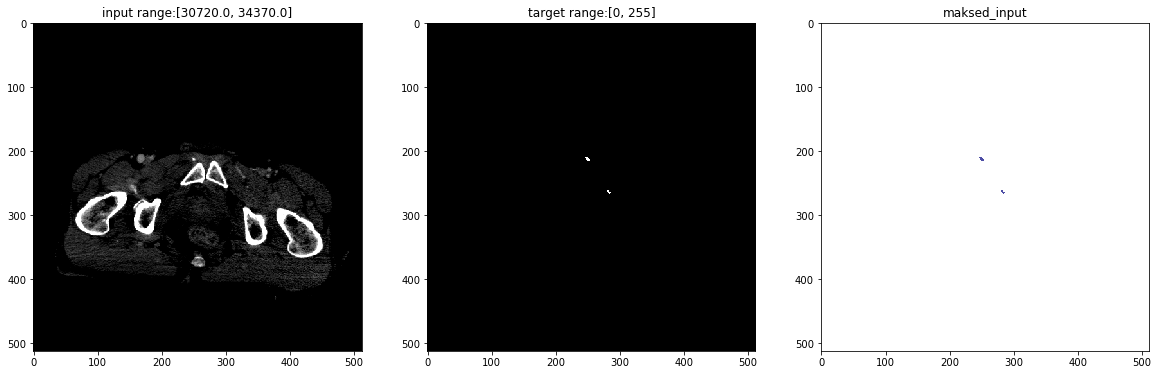

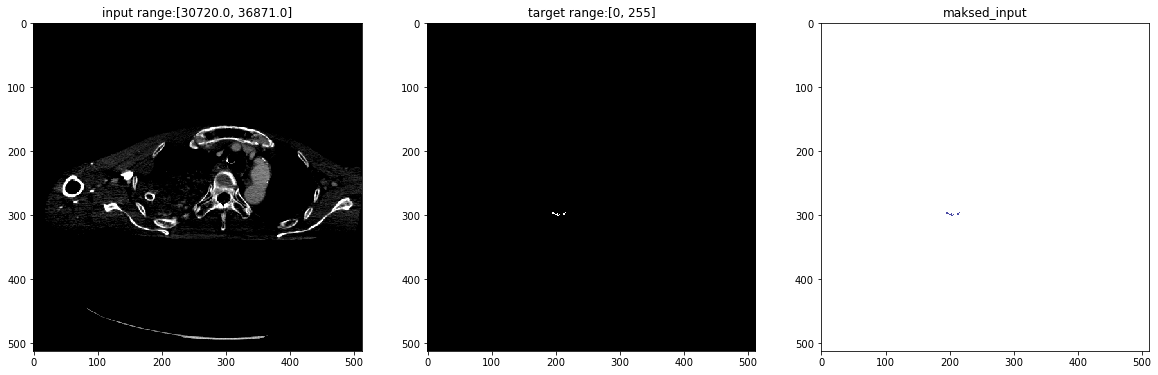

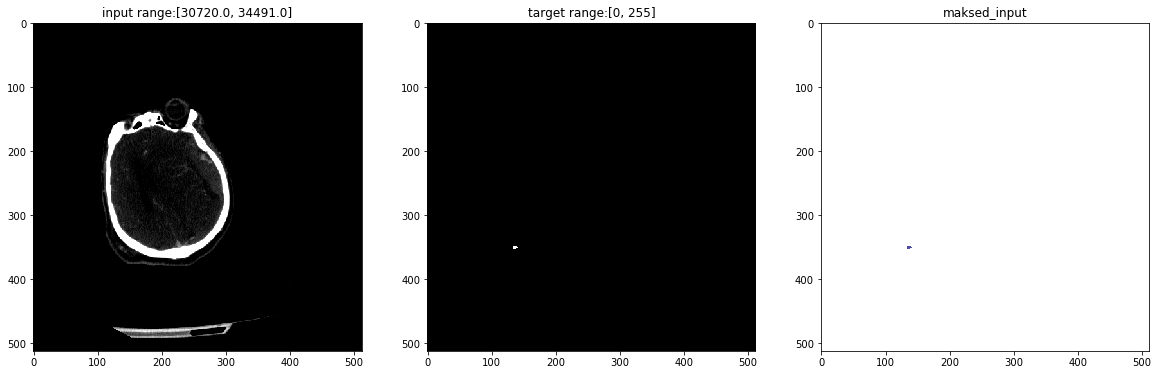

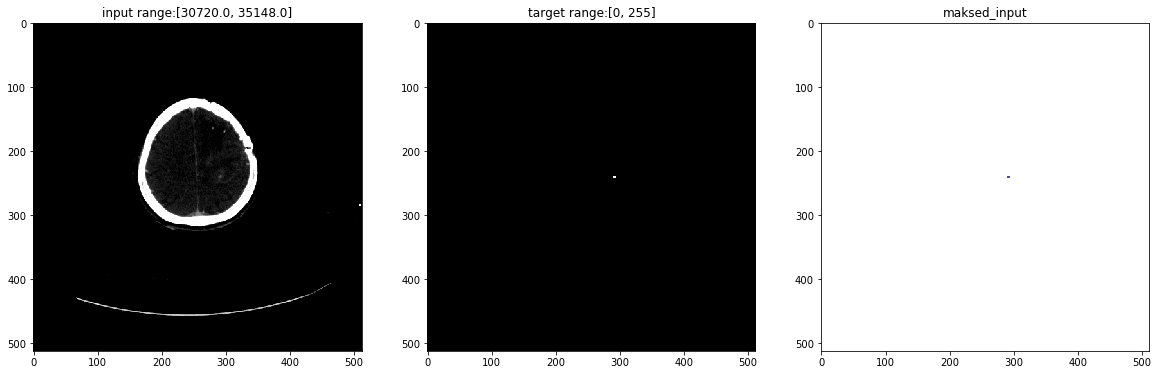

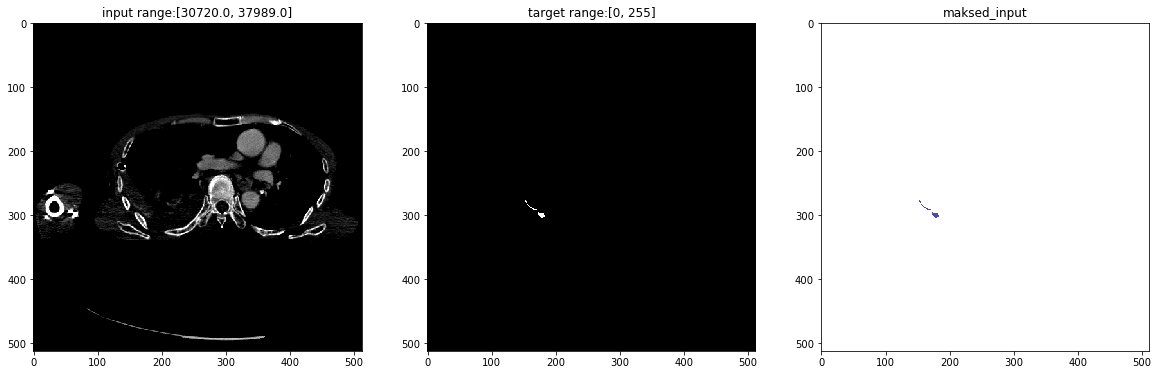

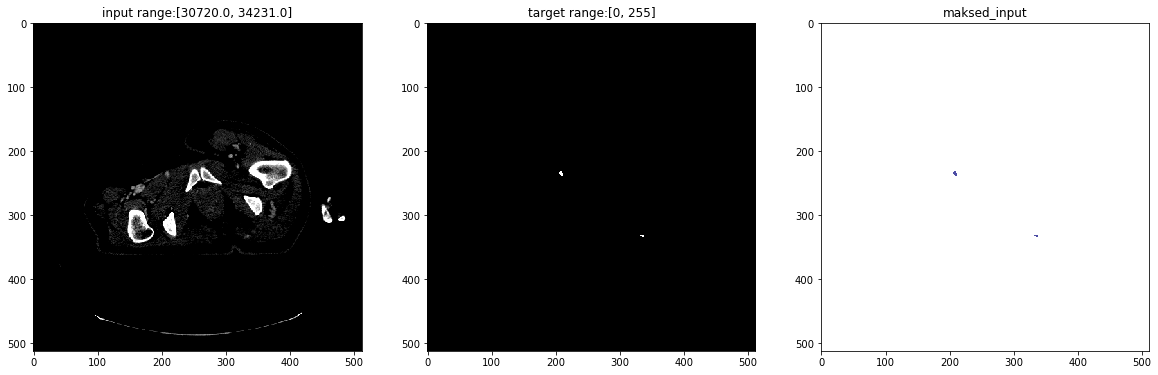

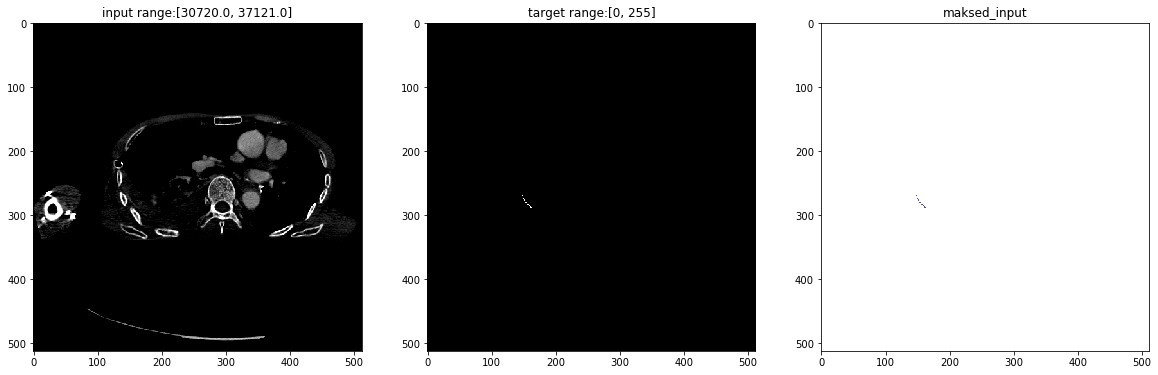

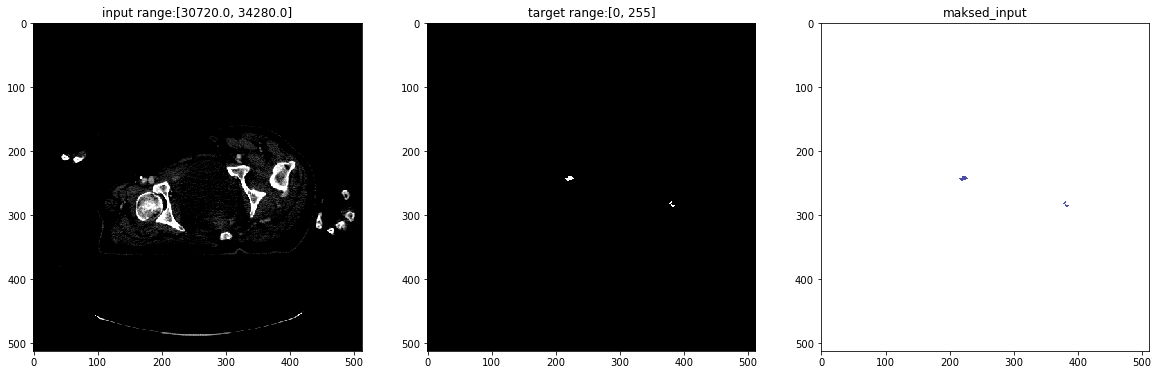

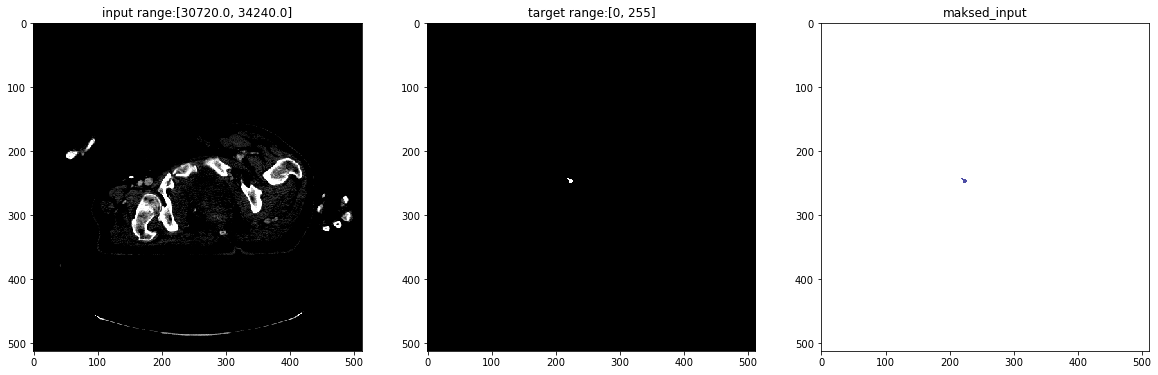

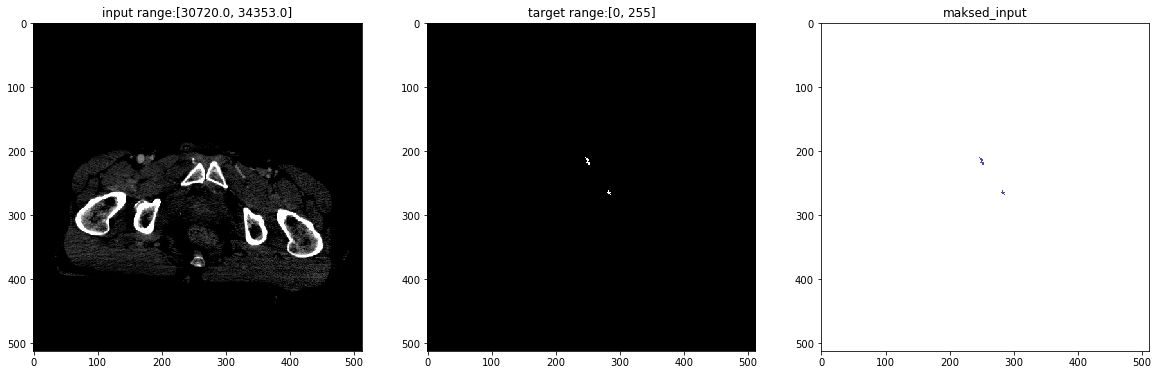

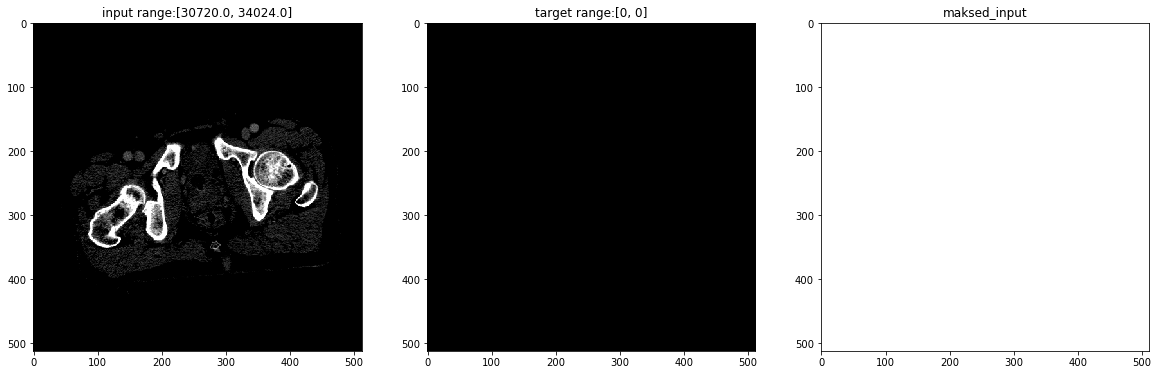

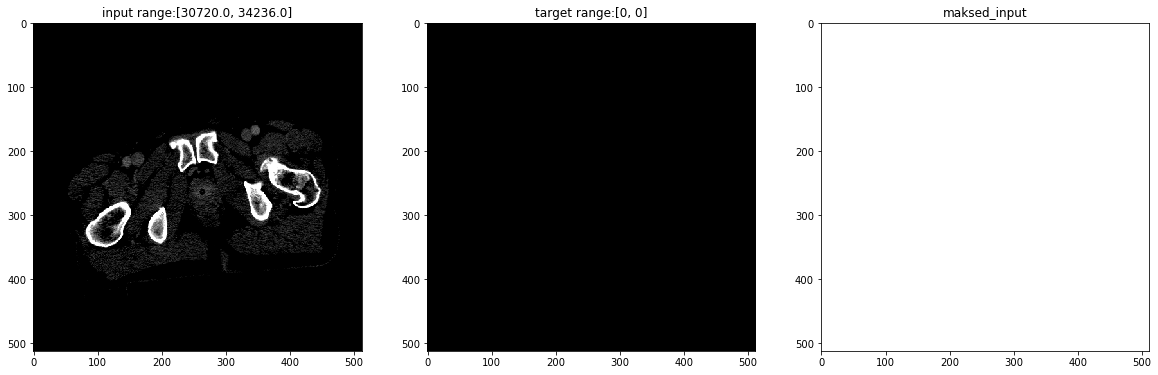

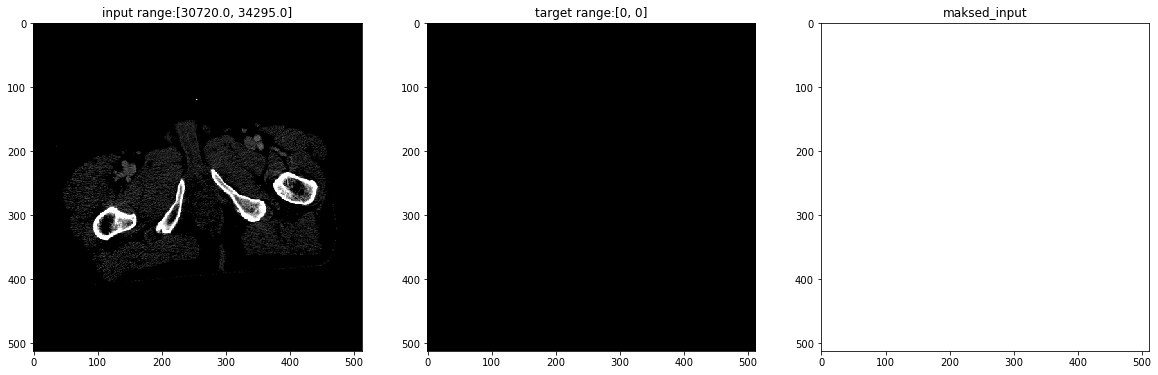

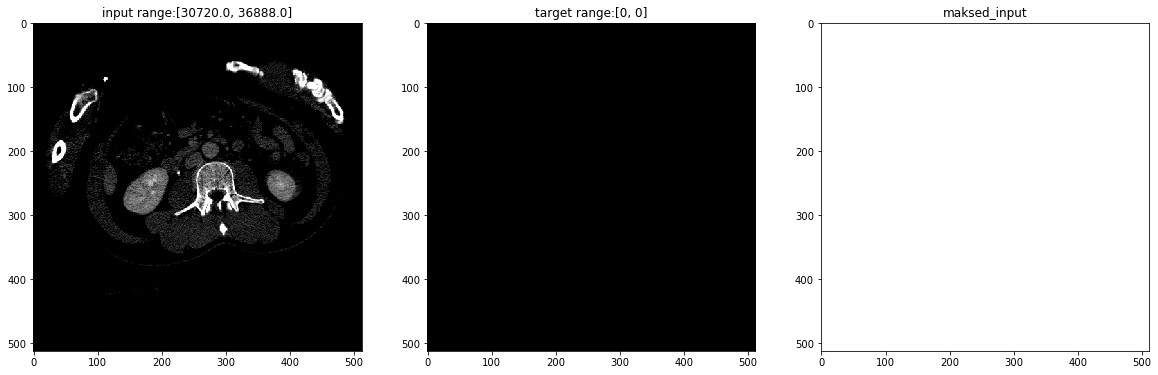

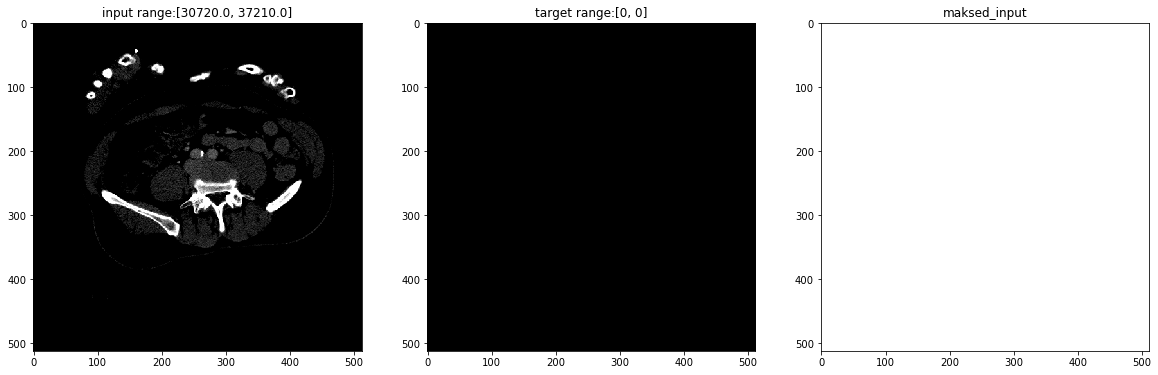

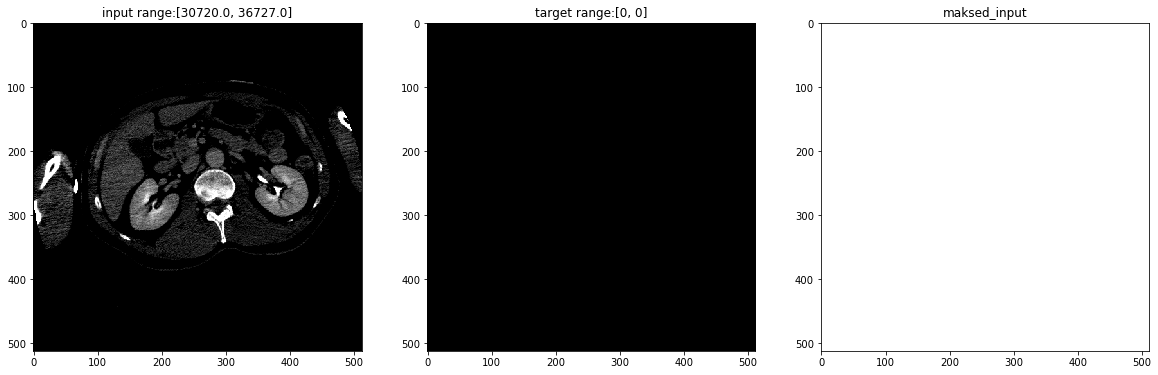

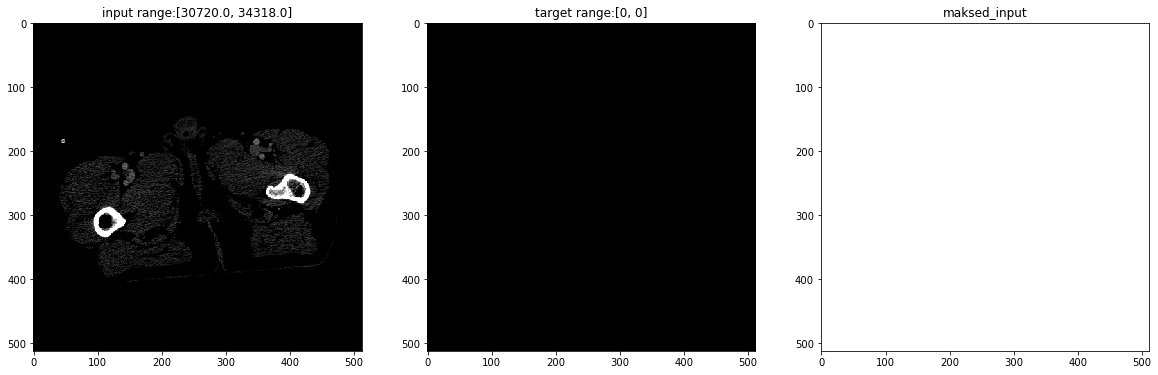

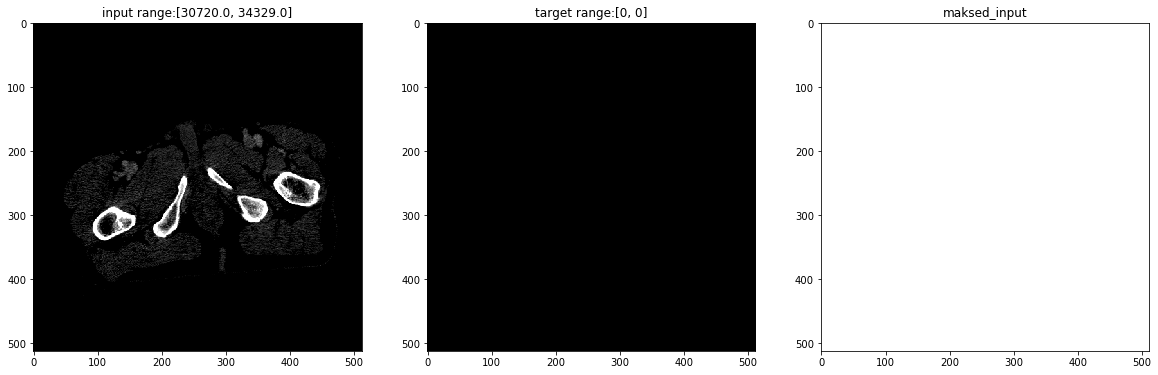

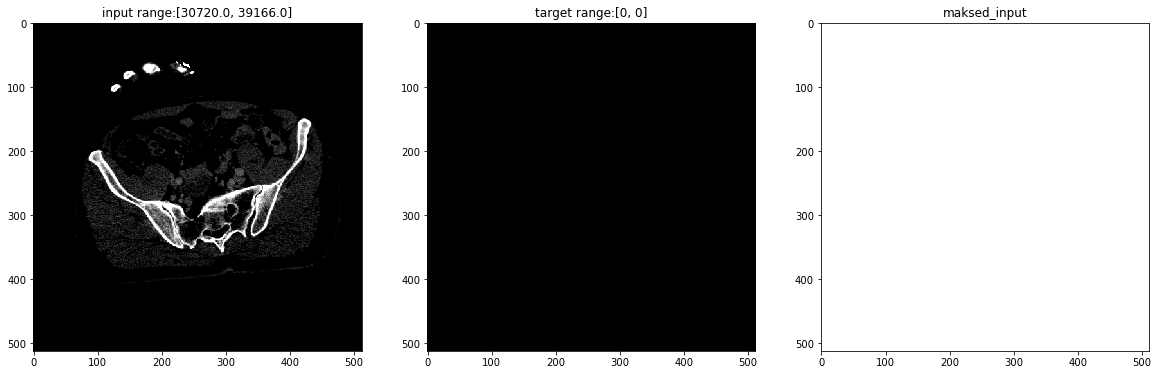

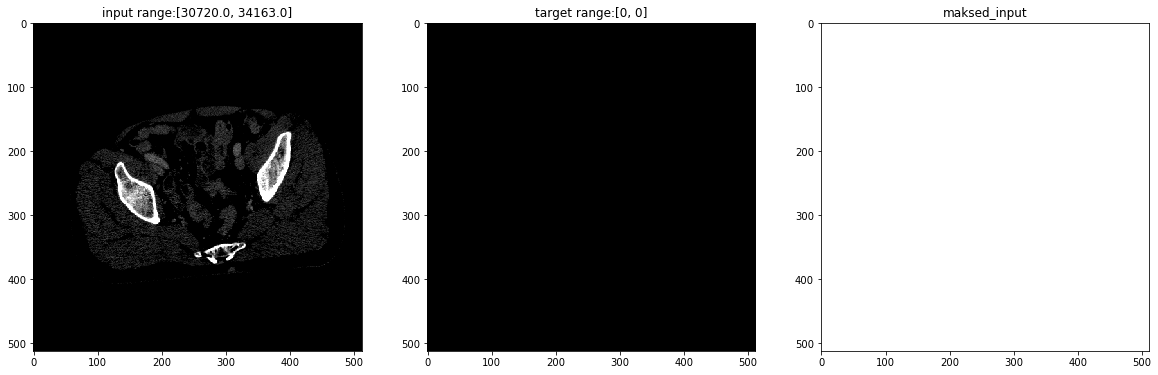

In [15]:
# check generated positive samples
import tensorflow_io as tfio
import matplotlib.pyplot as plt
train_positive_dataset = tf.data.TFRecordDataset('train_positive_samples.tfrecords')
train_negative_dataset = tf.data.TFRecordDataset('train_negative_samples.tfrecords')
# Create a dictionary describing the features.
image_feature_description = {
        'dicom_path': tf.io.FixedLenFeature([], tf.string),
        'seg_label': tf.io.FixedLenFeature([], tf.string), 
        'cls_label': tf.io.FixedLenFeature([], tf.int64),
}


def _parse_image_function(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, image_feature_description)
    # Parse the input tf.Example proto using the dictionary above.
    
    
    # decode dicom
    dicom_path = parsed_features["dicom_path"]
    image_bytes = tf.io.read_file(dicom_path)
    input_image = tf.cast(tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16), tf.float32)
    # decode mask
    seg_label = tf.io.decode_raw(parsed_features['seg_label'], tf.uint8)
    return dicom_path, input_image, seg_label,  parsed_features["cls_label"]


parsed_train_positive_dataset = train_positive_dataset.map(_parse_image_function)
parsed_train_negative_dataset = train_negative_dataset.map(_parse_image_function)

def check_dataset(dataset):
    # window the input
    def winwise(input,LB,HB):
        # 20 ,380 for range (-32768, 32767)
        # for tf input , (0, 65535)-? LB =  32788, 33148
        input[input<LB] = LB # low boundary , if < LW , set to LW
        input[input>HB] = HB # high boundary, if > Hw, Set to 255
        return input

    # print(len(parsed_train_positive_dataset))
    BUFFER_SIZE =512
    # random shuffle the train positive dagtaset
    parsed_dataset = dataset.shuffle(BUFFER_SIZE)

    for image_features in parsed_dataset.take(10):
        dicom_path =  image_features[0]
        input =  image_features[1]
    #     dicom_path = image_features[0].numpy()
        target = image_features[2]
        cls_label = image_features[3]
        print("dicom_path:", dicom_path)
        print("input_image.shape", input.shape)
    #     print("dicom_path", dicom_path)
    #     print("dicom_path:", dicom_path)
        print("seg_label", target.shape)
        print("cls_label", cls_label)

        # reshape label 
        target =  tf.reshape(target, input.shape)
        fig, axes = plt.subplots(1,3, figsize=(20,20))

        # 
        mask =  np.squeeze(target.numpy())
        input_arr = np.squeeze(winwise(input.numpy(), 32788,33148 ))
        masked_in = mask + input_arr
        masked = np.ma.masked_where(mask == 0, mask)

        axes[0].imshow(np.squeeze(winwise(input.numpy(), 32788,33148 )), cmap='gray')
        axes[0].set_title('input range:[{}, {}]'.format((input.numpy().min()), np.max(input.numpy())))
        axes[1].imshow(np.squeeze(target.numpy()), cmap='gray')
        axes[1].set_title('target range:[{}, {}]'.format(np.min(target), np.max(target)))
        axes[2].imshow(masked, 'jet', interpolation='none', alpha=0.7)
        axes[2].set_title("maksed_input")
        print(dicom_path)

        
check_dataset(parsed_train_positive_dataset)
check_dataset(parsed_train_negative_dataset)

## Generate Val TFRECORDS

In [18]:
# for val
val_root_folder_path_for_cases= "E:/dataset/Leisang/myTry/BleedingDataDCM/val/"

## Make into functions for genrerate tf records
val_positive_samples_file = 'val_positive_samples.tfrecords'
val_negative_samples_file = 'val_negative_samples.tfrecords'

# excel file
val_excel_loc = "E:\\dataset\\Leisang\\myTry\\BleedingDataDCM/ValfilpOrNot.xlsx"
print("val_excel_loc:", val_excel_loc)


# make positive and negative samples:
val_positive_samples, val_negative_samples = make_samples(root_folder_path_for_cases=val_root_folder_path_for_cases,
                                                              excel_loc = val_excel_loc)

total 2113 checked ---------------------------------------------------------------------------->
generate positive 238 positive samples at currently case step:
generate positive 4220 negative samples at currently case step:


In [19]:
# make val_positive
Make_TFRecords(feature_samples_dict=val_positive_samples, file_name=val_positive_samples_file)

Generation of TFRecords is finished.


In [20]:
# make val_positive
Make_TFRecords(feature_samples_dict=val_negative_samples, file_name=val_negative_samples_file)

Generation of TFRecords is finished.


dicom_path: tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-051_001\\00000145.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-051_001\\00000145.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-051_001\\00000147.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-051_001\\00000147.DCM', shape=(), dtype=string)
dicom_path: tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-049_001\\00001015.DCM', shape=(), dtype=string)
input_image.shape (1, 512, 512, 1)
seg_label (262144,)
cls_label tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM/val\\ZA-049_001\\00001015.DCM', shape=(), dtype=string)
dicom_p

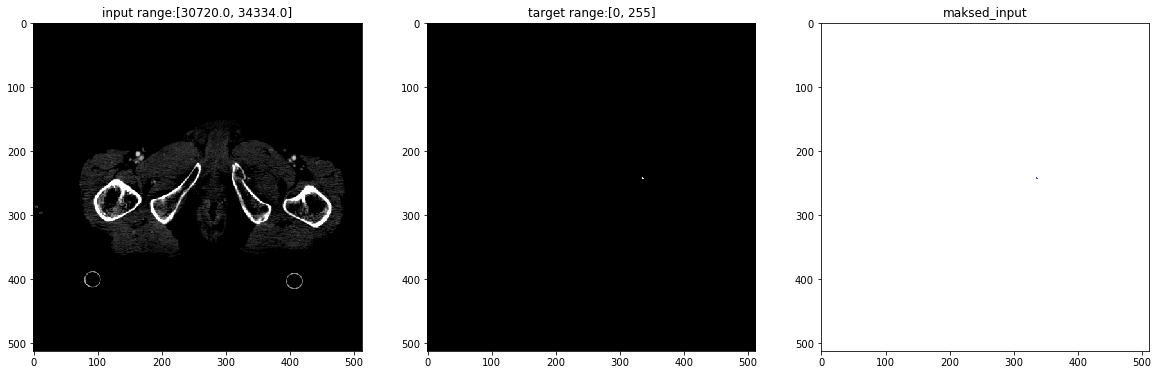

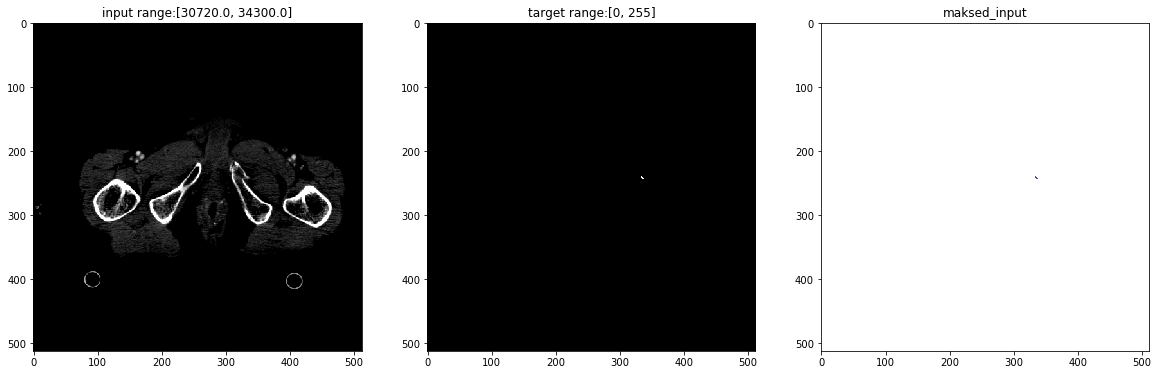

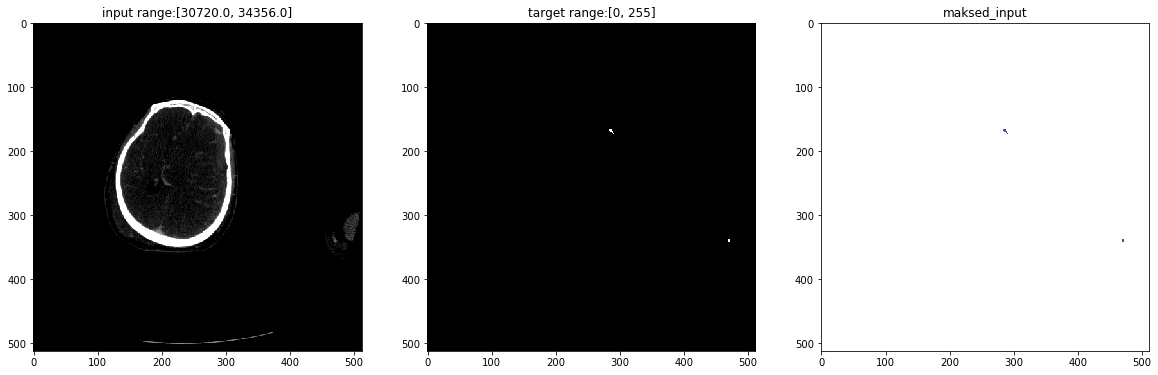

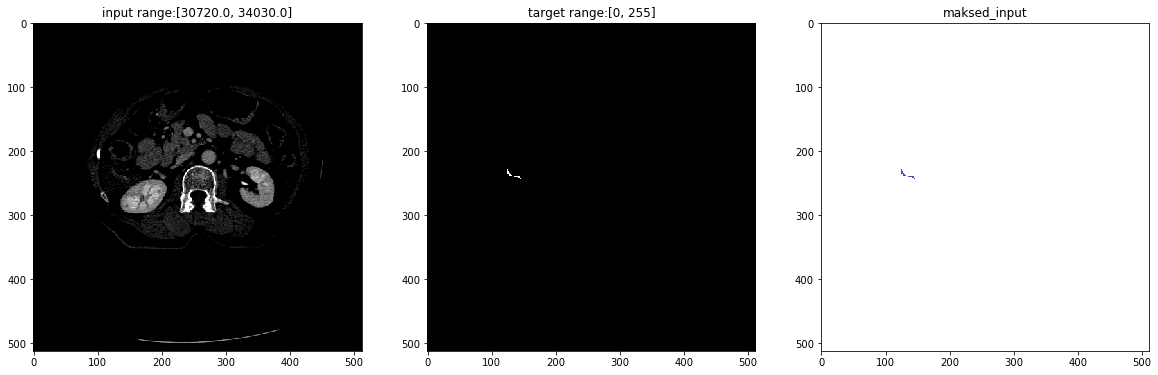

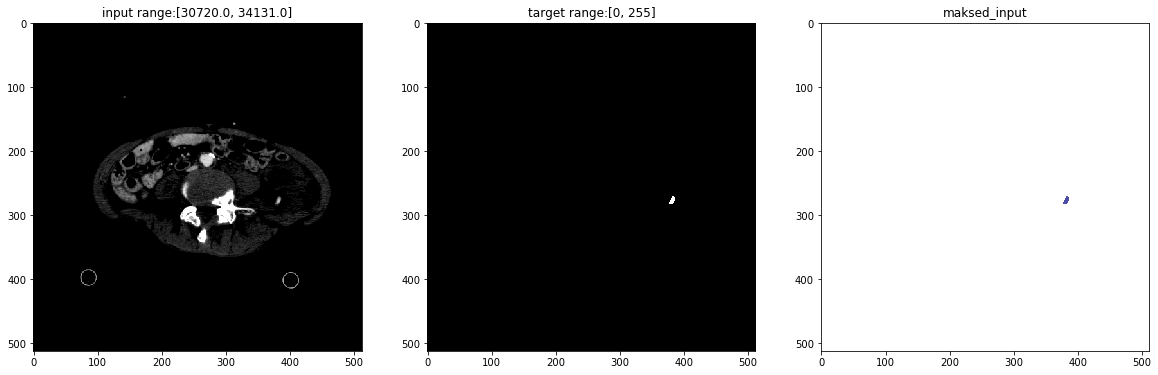

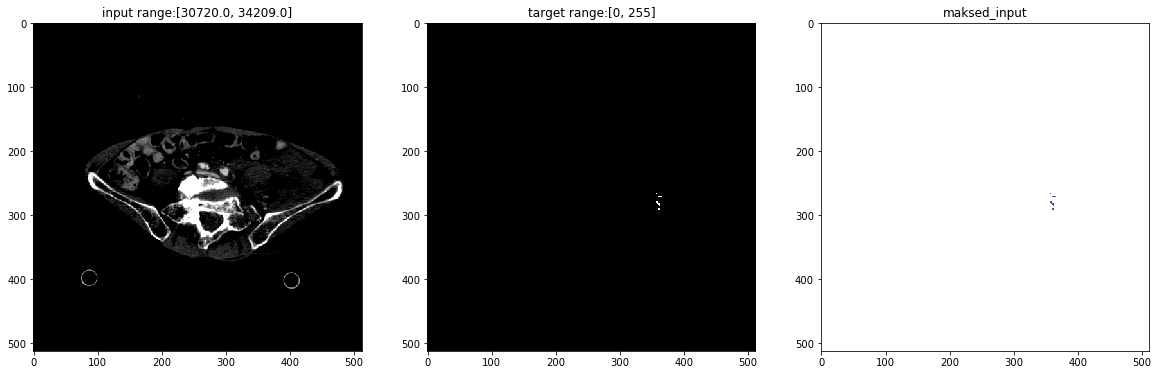

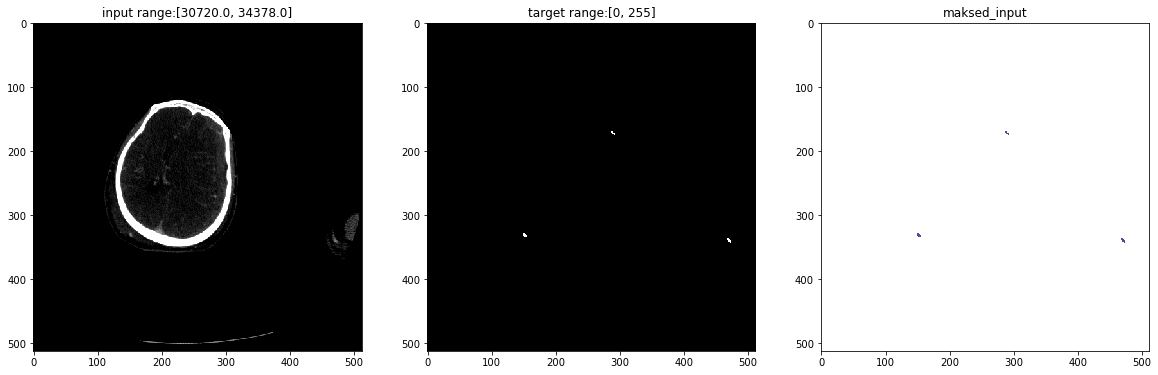

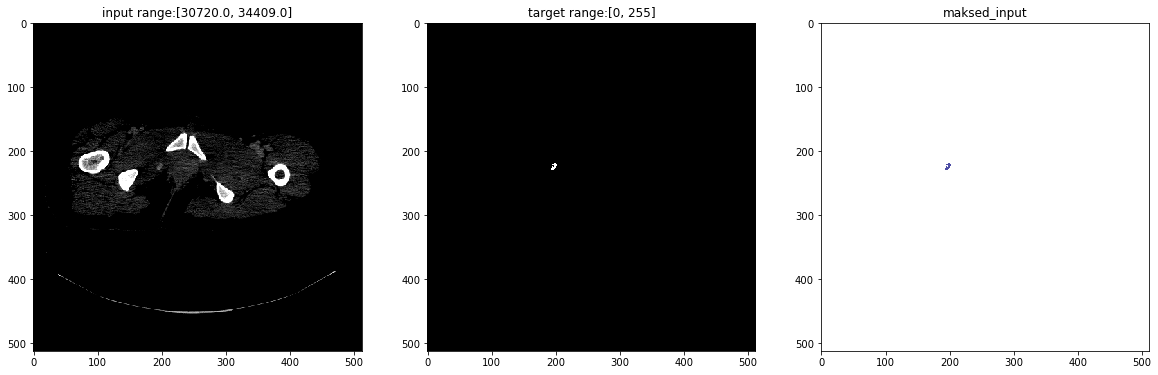

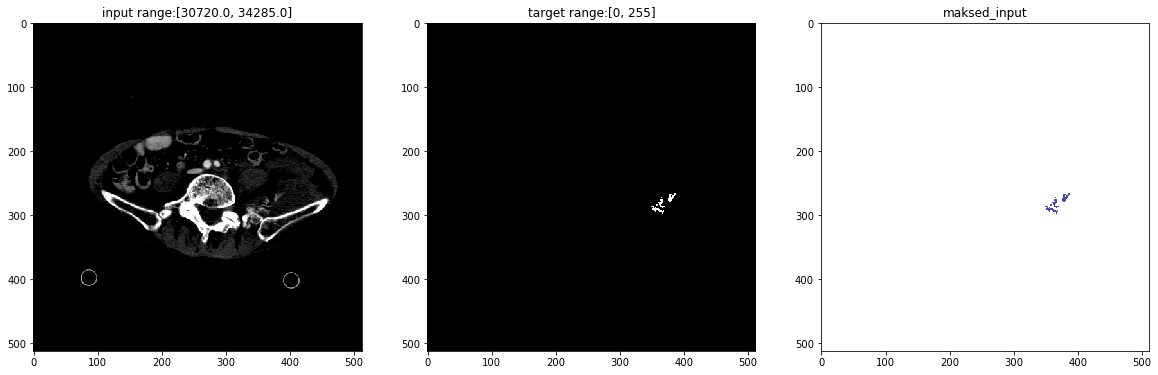

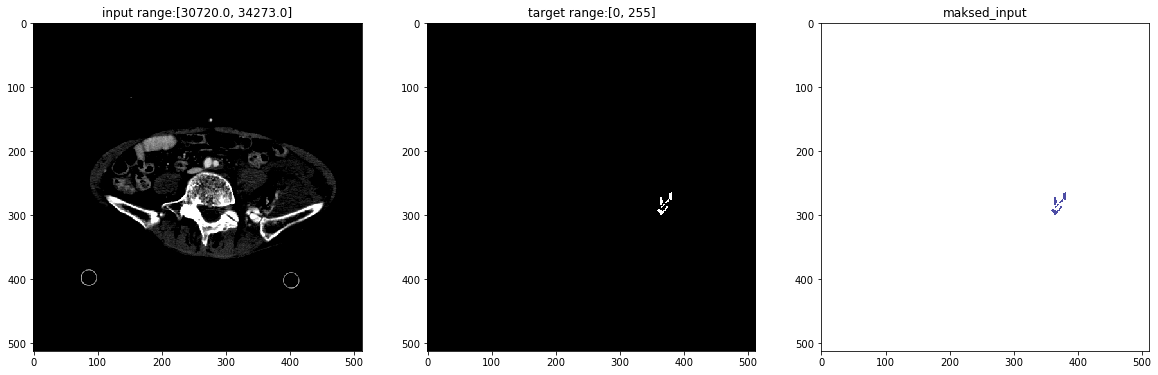

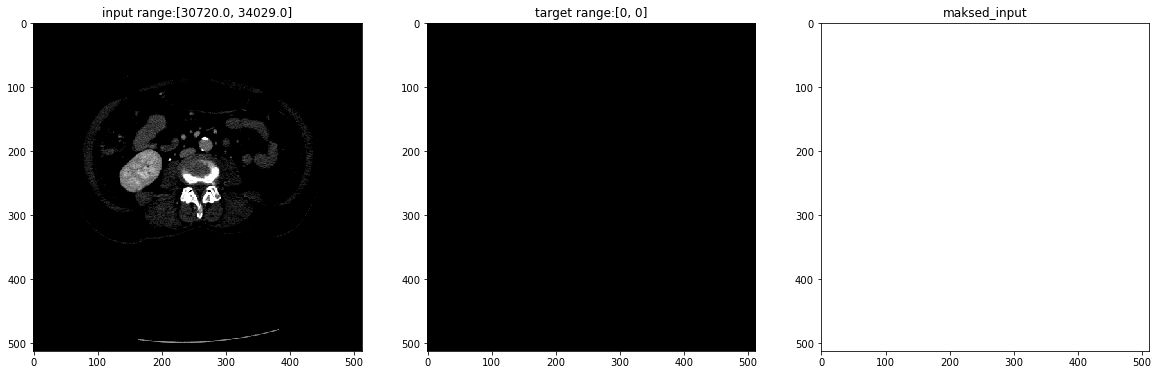

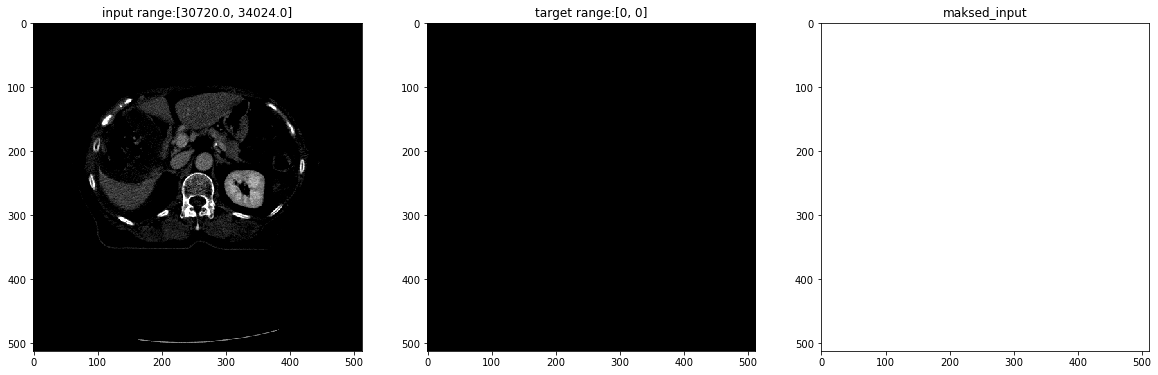

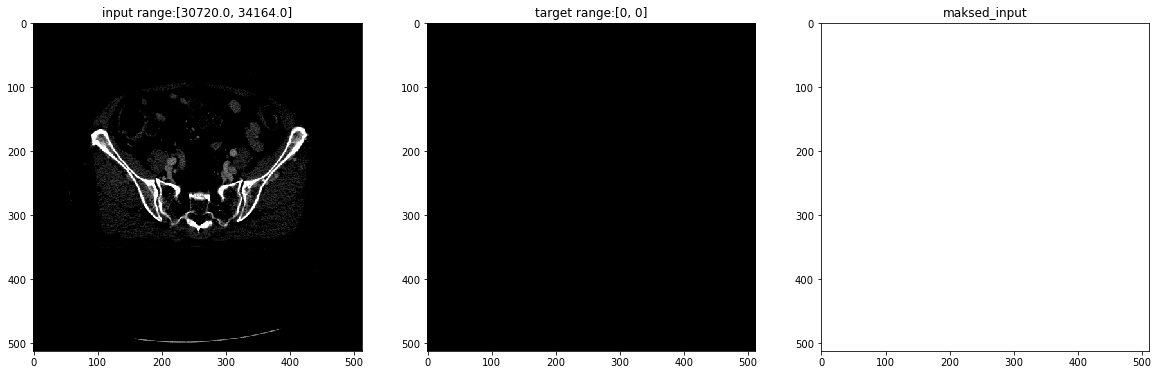

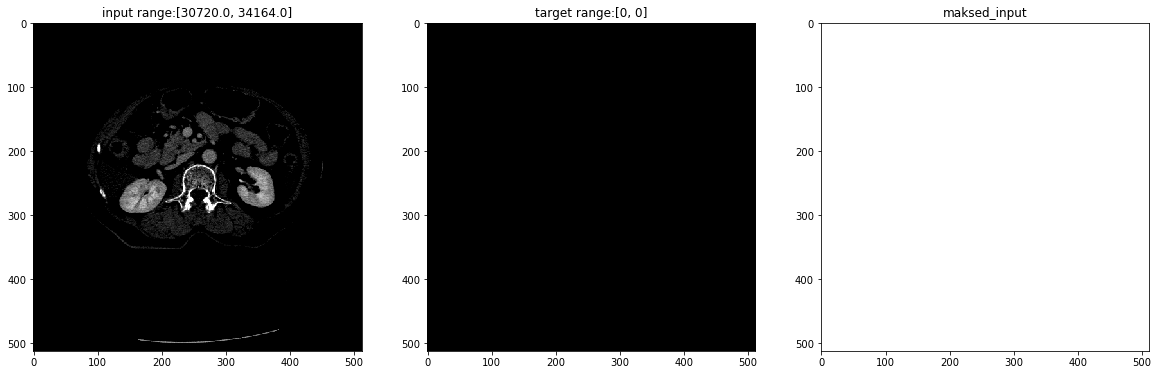

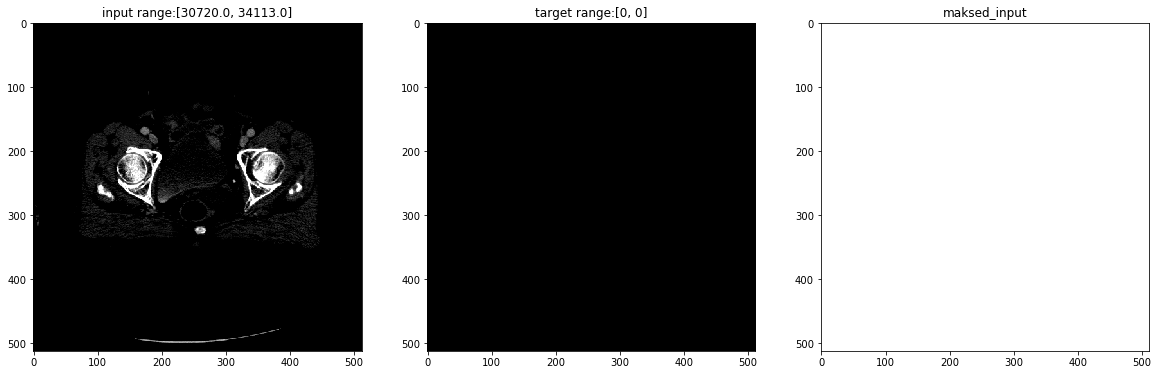

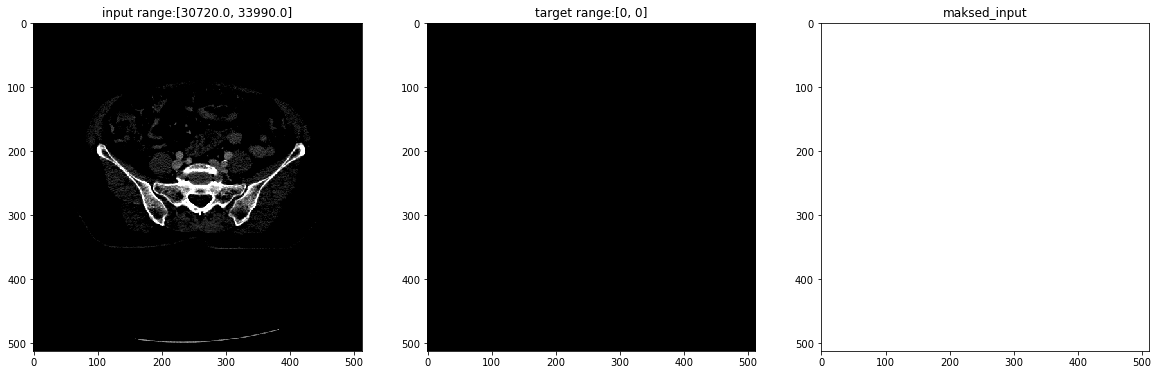

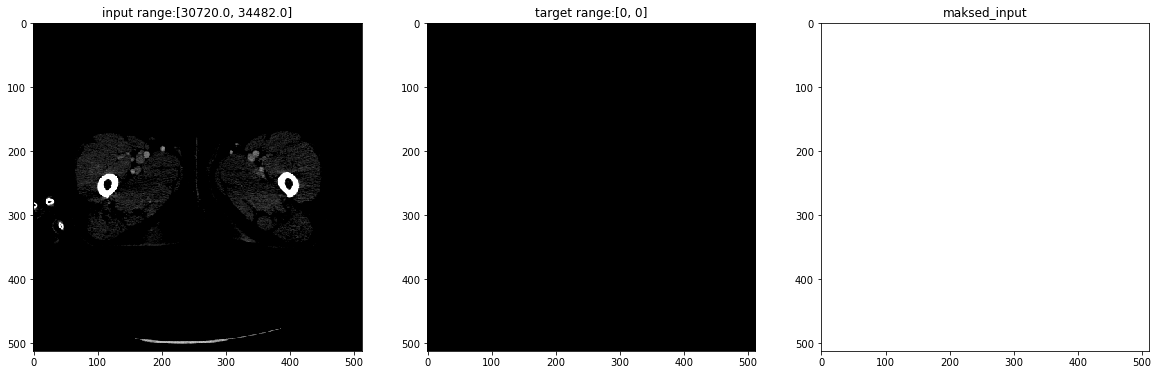

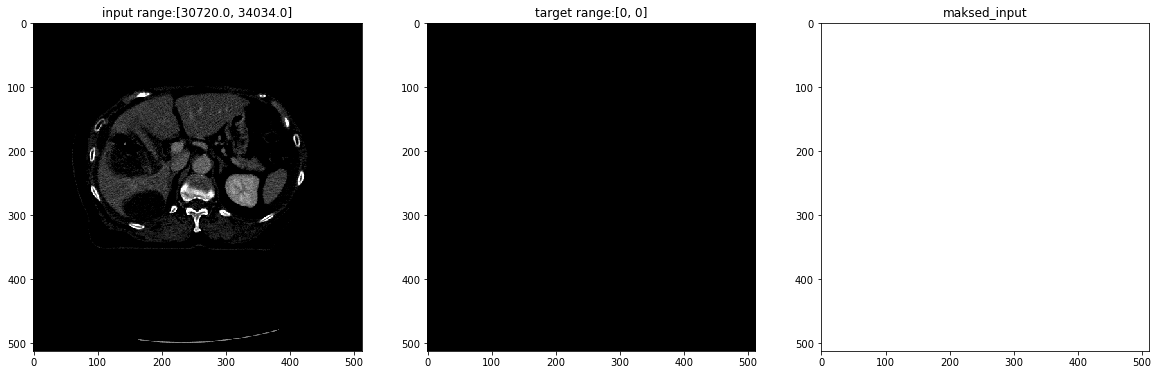

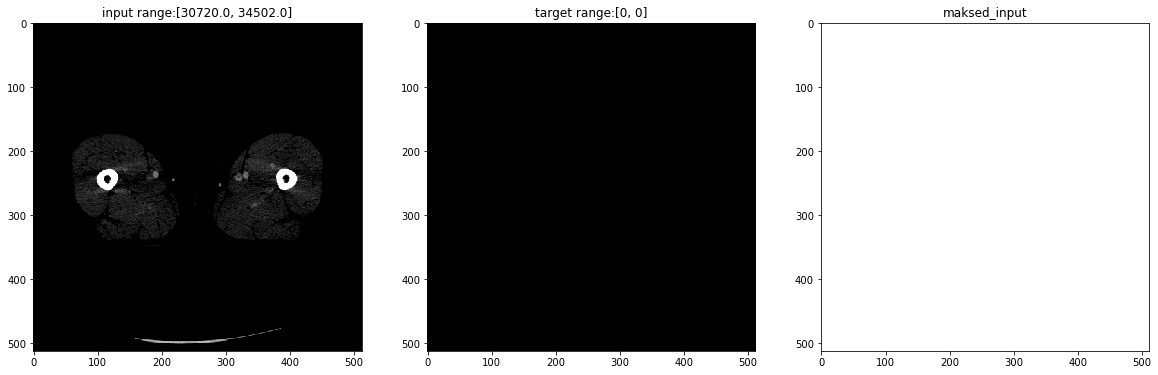

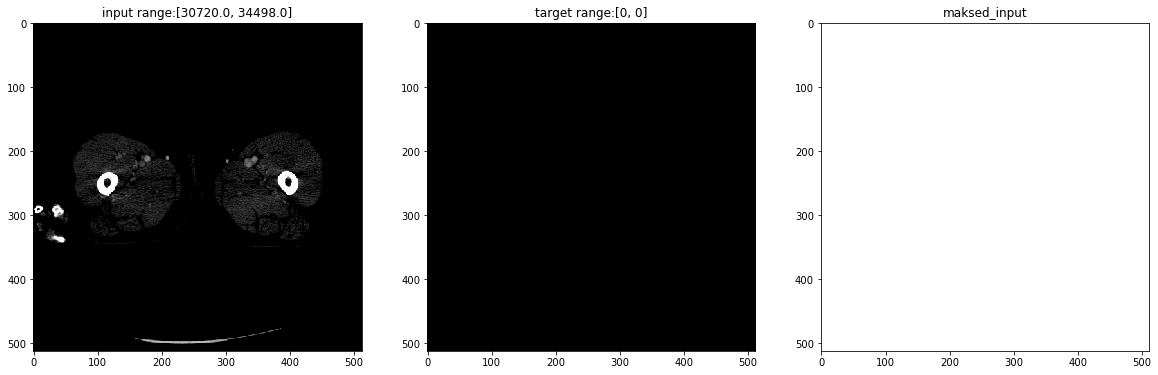

In [21]:
# check validation dataset
val_positive_dataset = tf.data.TFRecordDataset('val_positive_samples.tfrecords')
val_negative_dataset = tf.data.TFRecordDataset('val_negative_samples.tfrecords')
parsed_val_positive_dataset = val_positive_dataset.map(_parse_image_function)
parsed_val_negative_dataset = val_negative_dataset.map(_parse_image_function)

check_dataset(parsed_val_positive_dataset)
check_dataset(parsed_val_negative_dataset)